Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [ ]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [ ]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [ ]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [ ]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [ ]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [ ]:
# imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import category_encoders as ce
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV

In [ ]:
# look at data
df.describe(exclude='number')

,Burrito,Date,Chips,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
count,421,421,26,33,7,179,158,154,159,127,92,51,21,21,6,36,35,11,7,7,1,8,38,7,15,17,4,7,2,4,4,1,5,3,3,2,13,3,1,421
unique,5,169,4,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,2,1,2
top,California,8/30/2016,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,False
freq,169,29,21,33,5,137,127,114,128,102,67,36,20,17,4,26,27,9,5,4,1,6,33,6,9,9,3,5,2,4,4,1,5,3,3,2,13,2,1,239


In [ ]:
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [ ]:
# recode inputs of 'x' to 1
df = df.replace({'x':1,
                 'X':1,
                 'Yes':1,
                 'No':0})

In [ ]:
# feature engeneering to gain total number of fillings.
df['num_fillings'] = df.iloc[:,22:58].apply(pd.to_numeric,errors='coerce').sum(axis=1)

In [ ]:
# creat date time format for train/val/test split
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
# year column for train/val/test seperation
df['Year'] = df['Date'].map(lambda x: x.year)

In [ ]:
# create train, val, and test data sets
train =df[df['Year']<=2016]
val = df[df['Year'] == 2017]
test = df[df['Year'] > 2017]

In [ ]:
# check size
train.shape, val.shape, test.shape

((298, 61), (85, 61), (38, 61))

In [ ]:
# feature selection and x,y variables for train/val/test

target = 'Great'
features = ['Cost','Tortilla','Temp','Meat','Fillings','Meat:filling',
            'Uniformity','Salsa','Synergy','Wrap','Yelp']

X_train = train[features]
X_val = val[features]
X_test = test[features]

y_train = train[target]
y_val = val[target]
y_test = test[target]

In [ ]:
# base line 

y_train.value_counts(normalize=True)

# if we said every burrito is NOT great then we would be right 59% of the time 
# on the training set.

False    0.590604
True     0.409396
Name: Great, dtype: float64

In [ ]:
# encode train and val (nocolumns need encoding just practice)
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

# interprate missing values (in this case as 'mean')
imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

# scale data 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

# build model 
model = LogisticRegressionCV()
model.fit(X_train_scaled,y_train)

# predict val set
y_pred = model.predict(X_val_scaled)

# check accuracy
accuracy_score(y_val, y_pred)

0.8823529411764706

In [ ]:
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients

Cost            0.190331
Tortilla        0.315586
Temp            0.286277
Meat            0.571065
Fillings        0.586968
Meat:filling    0.490813
Uniformity      0.168618
Salsa           0.257708
Synergy         0.691671
Wrap            0.102576
Yelp            0.099018
dtype: float64

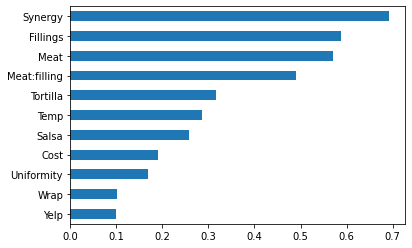

In [ ]:
coefficients.sort_values().plot.barh();

In [ ]:
# predict test data and get accuracy score
X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)
y_pred = model.predict(X_test_scaled)
accuracy_score(y_pred,y_test)
# beat baseline 

0.7894736842105263